In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import pandahouse as ph
import matplotlib.gridspec as gridspec
import requests
import datetime
from dotenv import load_dotenv

global y_day
y_day = datetime.datetime.today().date() - datetime.timedelta(1) #вчера

In [54]:
def connect_bd(q):
    load_dotenv()
    
    HOST = os.getenv('HOST')
    DATABASE = os.getenv('DATABASE')
    USER = os.getenv('USER')
    PASSWORD = os.getenv('PASSWORD')
    
    connection_ = {'host': HOST,
                   'database': DATABASE,
                   'user': USER,
                   'password':  PASSWORD}
    
    data = ph.read_clickhouse(q, connection=connection_)
    return data

In [66]:
#получение данных для графика декомпозиции количества пользователей по неделям
def new_gone_ret(schema):
    q = """WITH main_table as (SELECT user_id, 
    groupUniqArray(toMonday(toDate(time))) as weeks_visited, 
    arrayJoin(groupUniqArray(toMonday(toDate(time)))) as this_week,
    addWeeks(arrayJoin(weeks_visited), +1) as next_week, 
    addWeeks(arrayJoin(weeks_visited), -1) as prev_week,
    if(has(weeks_visited, next_week) = 1, 'ret', 'gone') as status_next_week, 
    if(has(weeks_visited, prev_week) = 1, 'ret', 'new') as status_this_week 
    FROM {db}."""+schema+"""
    group by user_id)

    select this_week, new_users, retention_users, gone_users from

    (SELECT this_week, count(user_id) as new_users FROM main_table
    group by this_week) t1

    LEFT JOIN

    (SELECT next_week, 
        countIf(user_id, status_next_week = 'ret') as retention_users, 
        -countIf(user_id, status_next_week = 'gone') as gone_users 
    FROM main_table
    group by next_week) t2

    ON t1.this_week = t2.next_week
    ORDER BY this_week"""
    
    return connect_bd(q)

#получение данных суточной активность ленты и мессенджера
def get_day_feed_and_mes():
    q_day_feed_and_mes = """select time, count(user_id) as count_users from 
    (SELECT toStartOfHour(time) as time,
            user_id
    FROM {db}.message_actions
    WHERE toStartOfHour(time) >= toStartOfHour(now()) - INTERVAL 47 HOUR) t1
    join
    (SELECT distinct user_id
    FROM {db}.feed_actions
    WHERE toStartOfHour(time) >= toStartOfHour(now()) - INTERVAL 47 HOUR) t2
    on t1.user_id = t2.user_id
    group by time
    order by time"""
    return connect_bd(q_day_feed_and_mes)
    
#получение данных суточной активности ленты новостей
def day_feed():
    q_day_feed = """SELECT toStartOfHour(time) as time, count(user_id) as count_users
    FROM {db}.feed_actions
    WHERE toStartOfHour(time) >= toStartOfHour(now()) - INTERVAL 47 HOUR
    group by time
    order by time"""
    return connect_bd(q_day_feed)

#получение данных суточной активности мессенджера
def day_mes():
    q_day_mes = """SELECT toStartOfHour(time) as time, count(user_id) as count_users
    FROM {db}.message_actions
    WHERE toStartOfHour(time) >= toStartOfHour(now()) - INTERVAL 47 HOUR
    group by time
    order by time"""
    return connect_bd(q_day_mes)

#DAU по городам ленты новостей
def feed_city():
    cities = ['Moscow','Saint Petersburg','Yekaterinburg','Novosibirsk','Rostov']
    q_feed_city = """
    SELECT toDate(time) as date,
           count(distinct user_id) as DAU,
           city
    FROM {db}.feed_actions
    WHERE date <= toDate(\'"""+str(y_day)+"""\')+1 AND date >= toDate(\'"""+str(y_day)+"""\') - 7 AND
    country = 'Russia' AND city in """+str(cities)+"""
    GROUP BY date, city 
    ORDER BY date
    """
    return connect_bd(q_feed_city)

#DAU по городам мессенджера
def message_city():
    cities = ['Moscow','Saint Petersburg','Yekaterinburg','Novosibirsk','Rostov']
    q_message_city = """
    SELECT toDate(time) as date,
           count(distinct user_id) as DAU,
           city
    FROM {db}.message_actions
    WHERE date <= toDate(\'"""+str(y_day)+"""\')+1 AND date >= toDate(\'"""+str(y_day)+"""\') - 7 AND
    country = 'Russia' AND city in """+str(cities)+"""
    GROUP BY date, city 
    ORDER BY date
    """
    return connect_bd(q_message_city)

#метрики ленты новостей (среднее количество лайков, просмотров в день, dau)
def feed_metrics():
    q_feed_metrics = """select date, count(distinct user_id) as DAU, avg(Likes) as Avg_likes, avg(Views) as Avg_views from
    (SELECT toDate(time) as date,
           user_id,
           countIf(action = 'like') as Likes,
           countIf(action = 'view') as Views
    FROM {db}.feed_actions
    WHERE date <= toDate(\'"""+str(y_day)+"""\') AND date >= toDate(\'"""+str(y_day)+"""\') - 27
    GROUP BY date, user_id)
    group by date
    order by date
    """
    return connect_bd(q_feed_metrics)

#кол-во уникальных пользователей месседжера 
#и вовлеченность пользователей - количество отправленных сообщений/кол-во уникальных пользователей
def dau_message():
    q_dau_message = """SELECT toDate(time) as date,
           count(distinct user_id) as DAU,
           count(time)/DAU as ER 
    FROM {db}.message_actions
    WHERE date <= toDate(\'"""+str(y_day)+"""\') AND date >= toDate(\'"""+str(y_day)+"""\') - 27
    GROUP BY date
    ORDER BY date
    """
    return connect_bd(q_dau_message)

#кол-во уникальных пользователей месседжера и ленты новостей
def dau_mes_and_feed():
    q_dau_mes_and_feed = """
    select date, count(distinct user_id) as DAU from 
    (SELECT toDate(time) as date,
            user_id
    FROM {db}.message_actions
    WHERE date <= toDate(\'"""+str(y_day)+"""\') AND date >= toDate(\'"""+str(y_day)+"""\') - 27) t1
    join
    (SELECT distinct user_id
    FROM {db}.feed_actions
    WHERE toDate(time) <= toDate(\'"""+str(y_day)+"""\') AND toDate(time) >= toDate(\'"""+str(y_day)+"""\') - 27) t2
    on t1.user_id = t2.user_id
    group by date
    order by date"""
    return connect_bd(q_dau_mes_and_feed)

def get_word(data, column):
    dif = int(data.iloc[-1,column]) - int(data.iloc[-2,column])
    word = 'меньше' if dif < 0 else 'больше'
    return word, abs(dif)

In [67]:
def get_dashboard(dau_mes,data_feed,data_feed_city,data_message_city, data_dau_feed_and_mes, data_dau_feed, data_dau_mes,data_new_feed,data_new_message,dau_mes_and_feed):
    load_dotenv()
     
    TOKEN = os.getenv('TOKEN')  
    CHAT_ID = os.getenv('CHAT_ID') 

    metrics = 'Метрики от {0}\n\n\
Лента новостей\nDAU: {1}\n\
Среднее кол-во лайков на пользователя: {2}\n\
Среднее кол-во просмотров на пользователя: {3}\n\
Количество новых пользователей на этой неделе: {4},\
 что на {5} {6} по сравнению с прошлой неделей\n\
\nМессенджер\nDAU: {7}\n\
Вовлеченность пользователей: {8}\n\
Количество новых пользователей на этой неделе: {9},\
 что на {10} {11} по сравнению с прошлой неделей\n\n\
DAU ленты новостей и мессенджера: {12}'\
    .format(data_feed.iloc[-1,0].date(),
            data_feed.iloc[-1,1],
            round(data_feed.iloc[-1,2],1),
            round(data_feed.iloc[-1,3],1),
            data_new_feed.iloc[-1,1], get_word(data_new_feed, 1)[1], get_word(data_new_feed, 1)[0],
            dau_mes.iloc[-1,1],
            round(dau_mes.iloc[-1,2],1),
            data_new_message.iloc[-1,1], get_word(data_new_message, 1)[1], get_word(data_new_message, 1)[0],
            dau_mes_and_feed.iloc[-1,1])
    
    print(metrics)

#   для отправки в чат
#     url_for_text = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={CHAT_ID}&text={metrics}"        
#     requests.get(url_for_text)
    
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)
    fig = plt.figure(constrained_layout=True, dpi = 400, figsize = (9,13))
    GridSpec = gridspec.GridSpec(ncols=3, nrows=4, figure= fig)
    
    # Добавление фигур
    subfigure_1 = fig.add_subfigure(GridSpec[0,:])
    subfigure_1.suptitle('Суточная активность',fontweight='bold')
    subfigure_2 = fig.add_subfigure(GridSpec[1,:])
    subfigure_2.suptitle('DAU, WAU',fontweight='bold')
    subfigure_31 = fig.add_subfigure(GridSpec[2,:2])
    subfigure_31.suptitle('DAU по топ 5 городам',fontweight='bold')
    subfigure_32 = fig.add_subfigure(GridSpec[2,2])
    subfigure_32.suptitle('Мессенджер',fontweight='bold')
    subfigure_4 = fig.add_subfigure(GridSpec[3,:])
    subfigure_4.suptitle('Лента новостей', fontweight='bold')
    
    # Добавление сабплотов
    subplots_1 = subfigure_1.subplots(1,3)
    subplots_2 = subfigure_2.subplots(1,3)
    subplots_31 = subfigure_31.subplots(1,2)
    subplots_32 = subfigure_32.subplots(1,1)
    subplots_4 = subfigure_4.subplots(1,3)
    days_metrics = {'Мессенджер и лента новостей':data_dau_feed_and_mes,'Лента новостей':data_dau_feed,'Мессенджер':data_dau_mes}
    
    #Суточная активность
    for i, (key, val) in enumerate(days_metrics.items()):
        subplots_1[i].grid()
        subplots_1[i].plot(val.iloc[24:,0], val.iloc[24:,1], '-o', markersize = 3, 
                           linewidth = 2, label = 'Последние 24 часа', color = 'teal')
        subplots_1[i].plot(val.iloc[24:,0], val.iloc[:24,1], '--', linewidth = 2, 
                         label = 'Прошлые сутки', alpha = 0.7, color = 'teal')
        subplots_1[i].set_title(key, fontsize = 10)
        subplots_1[i].tick_params(labelsize = 7)
        subplots_1[i].legend(loc = 'upper left', fontsize = 7)
        subplots_1[i].tick_params('x',rotation = 45)
    subplots_1[0].set_ylabel('Количество пользователей')
    
    #DAU и WAU
    subplots_2[0].grid()
    subplots_2[0].plot(dau_mes_and_feed.iloc[:,0], dau_mes_and_feed.iloc[:,1], '-o', markersize = 3, 
                           linewidth = 2, color = 'seagreen')
    subplots_2[0].set_title('DAU, мессенджер и лента новостей', fontsize = 10)
    subplots_2[0].tick_params('x',rotation = 45)
    subplots_2[0].tick_params(labelsize = 7)
    subplots_2[1].grid()
    subplots_2[1].bar(data_new_feed.this_week, data_new_feed.iloc[:,1], width = 5,
                       label = 'Новые', zorder = 10)
    subplots_2[1].bar(data_new_feed.this_week, data_new_feed.iloc[:,2], width = 5,
                       label = 'Остались', zorder = 10)
    subplots_2[1].bar(data_new_feed.this_week, data_new_feed.iloc[:,3], width = 5,
                       label = 'Ушли', zorder = 10)
    subplots_2[1].set_title('Декомпозиция WAU, лента', fontsize = 10)
    subplots_2[1].legend(loc = 'lower left', fontsize = 7)
    subplots_2[1].tick_params('x',rotation = 45)
    subplots_2[1].tick_params(labelsize = 7)
    subplots_2[2].grid()
    subplots_2[2].bar(data_new_message.this_week, data_new_message.iloc[:,1], width = 5,
                       label = 'Новые', zorder = 10)
    subplots_2[2].bar(data_new_message.this_week, data_new_message.iloc[:,2], width = 5,
                       label = 'Остались', zorder = 10)
    subplots_2[2].bar(data_new_message.this_week, data_new_message.iloc[:,3], width = 5,
                       label = 'Ушли', zorder = 10)
    subplots_2[2].set_title('Декомпозиция WAU, мессенджер', fontsize = 10)
    subplots_2[2].legend(loc = 'lower left', fontsize = 7)
    subplots_2[2].tick_params('x',rotation = 45)
    subplots_2[2].tick_params(labelsize = 7)
    
    #Активность по топ 5 городам и вовлеченность пользователей мессенджера
    subplots_32.grid()
    subplots_32.plot(dau_mes.iloc[:,0], dau_mes.iloc[:,2], '-o', markersize = 3, 
                       linewidth = 2, color = 'salmon')
    subplots_32.set_title('Вовлеченность пользователей', fontsize = 10)
    subplots_32.tick_params('x',rotation = 45)
    subplots_32.tick_params(labelsize = 7)
    subplots_31[0].tick_params('x',rotation = 45)
    subplots_31[0].set_title('Лента новостей', fontsize = 10)
    subplots_31[0].grid()
    
    cities = ['Moscow','Saint Petersburg','Yekaterinburg','Novosibirsk','Rostov']
    for i, city in enumerate(cities):
        dau = data_feed_city[data_feed_city.city == city].DAU
        t = data_feed_city[data_feed_city.city == city].date
        subplots_31[0].bar(t,dau,label = city, zorder = 3)
        subplots_31[0].tick_params(labelsize = 7)
    subplots_31[1].tick_params('x',rotation = 45)
    subplots_31[1].set_title('Мессенджер', fontsize = 10)
    subplots_31[1].grid()
    for i, city in enumerate(cities):
        dau = data_message_city[data_message_city.city == city].DAU
        t = data_message_city[data_message_city.city == city].date
        subplots_31[1].bar(t,dau,label = city, zorder = 3)
        subplots_31[1].tick_params(labelsize = 7)
    subplots_31[1].legend(fontsize = 7, loc = 'upper left',)
    
    #Метрики ленты новостей
    for i, (key, val) in enumerate(data_feed.iloc[:,1:].to_dict('list').items()):
        subplots_4[i].grid()
        subplots_4[i].plot(data_feed.date[14:], val[14:], '-o', markersize = 3, 
                           linewidth = 2, color = 'indianred', label = 'Текущие 2 недели')
        subplots_4[i].plot(data_feed.date[14:], val[:14], '--', linewidth = 2, color = 'indianred', 
                         label = 'Предыдущие', alpha = 0.7)
        subplots_4[i].set_title(key, fontsize = 10)
        subplots_4[i].tick_params(labelsize = 7)
        subplots_4[i].legend(loc = 'upper left', fontsize = 7)
        subplots_4[i].tick_params('x',rotation = 45)

#для отправки в чат

#     plot_obj = io.BytesIO() # буфер
#     plt.savefig(plot_obj) # сохраняем туда красивую картинку
#     plot_obj.seek(0) # переносим курсор в начало
#     plot_obj.name = 'Дашборд.png'
#     plt.close()
#     url = f'https://api.telegram.org/bot{TOKEN}/sendPhoto'
#     files = {'photo': plot_obj}
#     data = {'chat_id': CHAT_ID}
#     response = requests.post(url, files=files, data=data)

Метрики от 2024-07-08

Лента новостей
DAU: 19665
Среднее кол-во лайков на пользователя: 6.9
Среднее кол-во просмотров на пользователя: 33.3
Количество новых пользователей на этой неделе: 35486, что на 50938 меньше по сравнению с прошлой неделей

Мессенджер
DAU: 2442
Вовлеченность пользователей: 5.3
Количество новых пользователей на этой неделе: 4007, что на 9684 меньше по сравнению с прошлой неделей

DAU ленты новостей и мессенджера: 2290


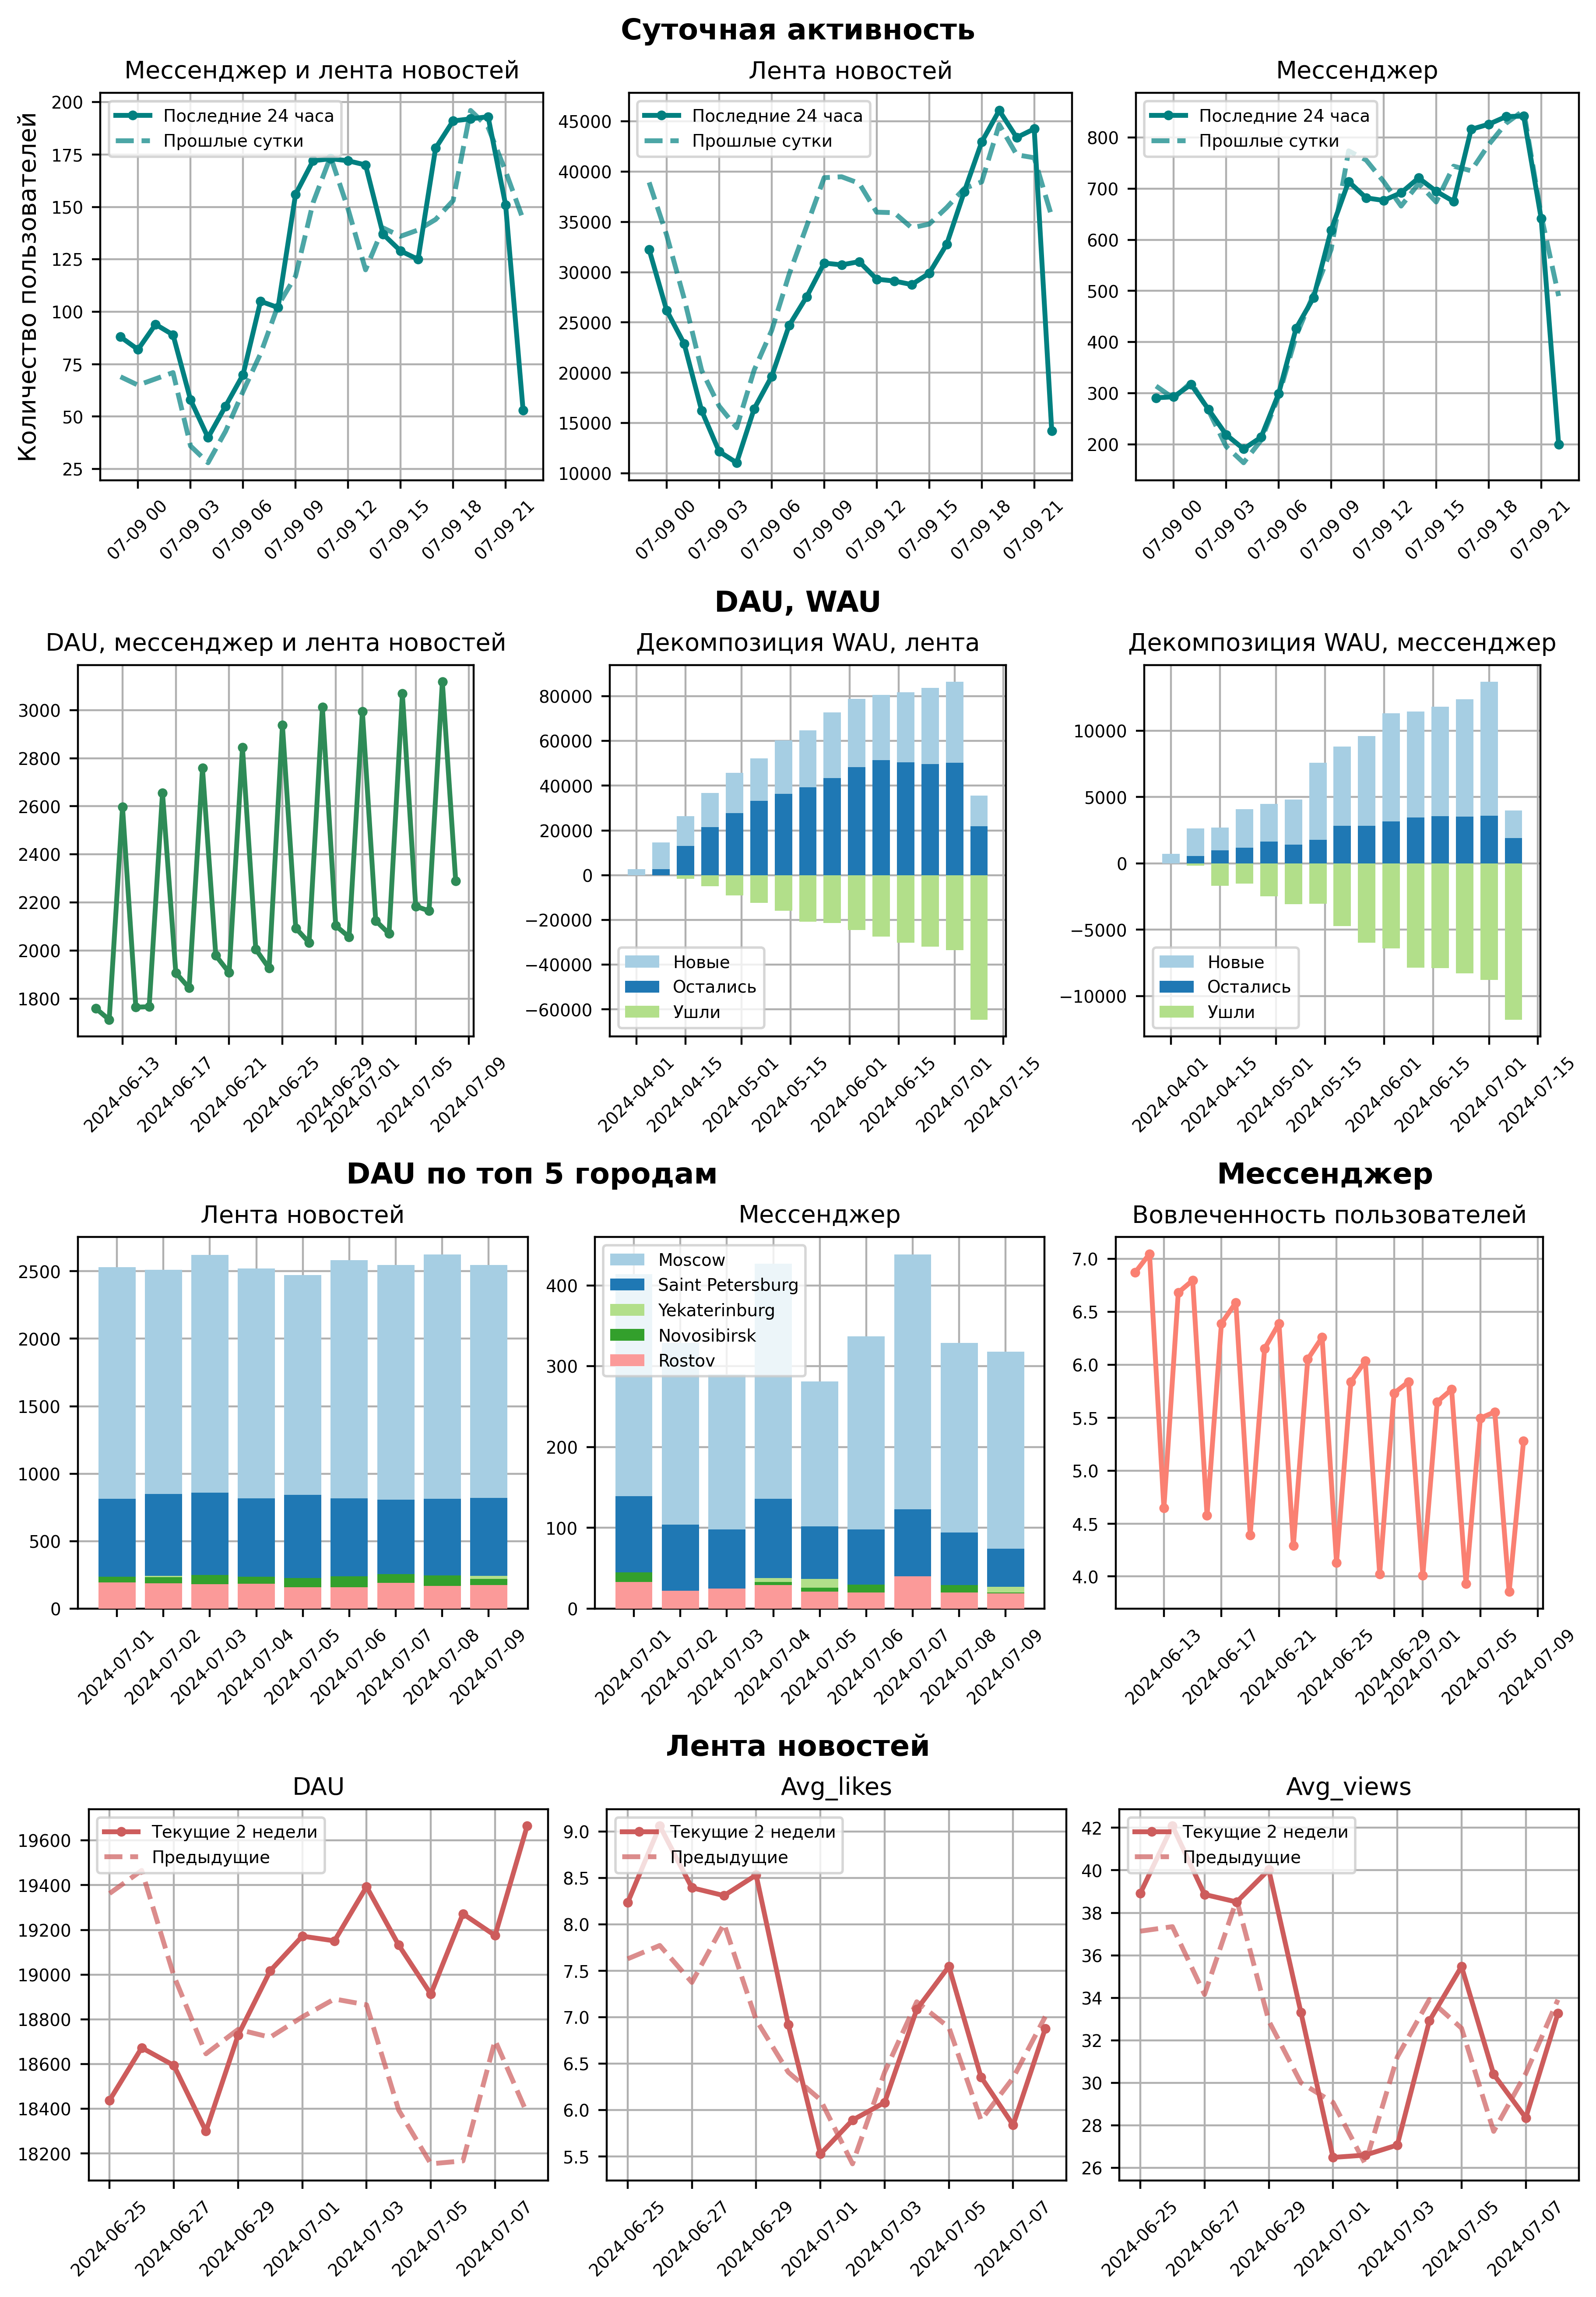

In [68]:
#DAU мессенджера
data_dau_message = dau_message()

#Метрики ленты новостей
data_feed = feed_metrics()

#DAU по городам для ленты новостей
data_feed_city = feed_city()

#DAU по городам для мессенджера
data_message_city = message_city()

#суточная активность мессенджера и ленты новостей
data_day_feed_and_mes = get_day_feed_and_mes()

#получение данных суточной активности ленты новостей
data_day_feed = day_feed()

#получение данных суточной активности мессенджера
data_day_mes = day_mes()

#новые, вернувшиеся и ушедшие пользователи ленты по неделям
data_new_feed = new_gone_ret('feed_actions')

#новые, вернувшиеся и ушедшие пользователи мессенджера по неделям
data_new_message = new_gone_ret('message_actions')

#DAU мессенджера и ленты новостей
data_dau_mes_and_feed = dau_mes_and_feed()

get_dashboard(data_dau_message,data_feed,data_feed_city,data_message_city,
              data_day_feed_and_mes, data_day_feed, data_day_mes, data_new_feed, data_new_message, data_dau_mes_and_feed) 